# Aula 09 - RNA (Redes Neuraus Artificiais)

Tópicos da aula de Hoje:

* Perceptron
* MLP
* Keras API - Tensorflow
* Model Fully connected
* Exemplo Pima Diabetes

https://towardsdatascience.com/choose-best-ml-model-based-on-visualization-ed6398ac3005

In [66]:
%load_ext tensorboard

In [14]:
import pandas as pd
import numpy as np
import datetime

import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, MinMaxScaler, StandardScaler

import imblearn
import keras_tuner as kt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model

In [15]:
df = pd.read_csv('diabetes.csv')

In [16]:
x_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

In [17]:
df.drop(df[df.Glucose < 20].index, inplace=True)
df.drop(df[df.BloodPressure < 15].index, inplace=True)
df.drop(df[df.BMI < 10].index, inplace=True)


In [18]:
media_SkinThickness = df['SkinThickness'].median()
media_Insulin = df['Insulin'].median()

In [19]:
df['SkinThickness'] = np.where(df['SkinThickness'] < 5, media_SkinThickness, df['SkinThickness'])
df['Insulin'] = np.where(df['Insulin'] < 10, media_Insulin, df['Insulin'])

In [20]:
X = df.get(x_features).values

In [21]:
y = df.get('Outcome').values

Normalizar os dados

In [27]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [28]:
X.shape

(724, 8)

In [30]:
X.max(), X.min()

(1.0000000000000002, 0.0)

Balancear os dados

In [37]:
oversample = imblearn.over_sampling.SMOTE()
X, y = oversample.fit_resample(X, y)

In [38]:
print(f'Positivos: {y.sum()} \t Negativos: {len(y) - y.sum()}')

Positivos: 475 	 Negativos: 475


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
X_test.shape, y_train.shape

((285, 8), (665,))

# Rede Neural - Modelo

In [67]:
model = tf.keras.models.Sequential()
model.add(Dense(20, input_dim=X.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])   # loss='mean_squared_error'

es = tf.keras.callbacks.EarlyStopping(patience=5)
log_dir = 'meus_logs' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tf_callback = tf.keras.callbacks.TensorBoard(
    log_dir = log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1
)

Métricas de treinamento e tensorboar

In [68]:
historico = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                      epochs=200, shuffle=True,
                      callbacks = [es]
                      )

Epoch 1/200
21/21 [==============================] - 0s 10ms/step - loss: 0.6939 - accuracy: 0.5203 - val_loss: 0.6924 - val_accuracy: 0.4807
Epoch 2/200
21/21 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.5218 - val_loss: 0.6921 - val_accuracy: 0.4596
Epoch 3/200
21/21 [==============================] - 0s 4ms/step - loss: 0.6760 - accuracy: 0.5113 - val_loss: 0.6926 - val_accuracy: 0.4596
Epoch 4/200
21/21 [==============================] - 0s 3ms/step - loss: 0.6639 - accuracy: 0.5564 - val_loss: 0.6891 - val_accuracy: 0.4596
Epoch 5/200
21/21 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.5549 - val_loss: 0.6796 - val_accuracy: 0.5018
Epoch 6/200
21/21 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6045 - val_loss: 0.6705 - val_accuracy: 0.6070
Epoch 7/200
21/21 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6391 - val_loss: 0.6657 - val_accuracy: 0.6281
Epoch 8/200


In [48]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 1ms/step - loss: 0.5650 - accuracy: 0.7298


[0.5649656653404236, 0.7298245429992676]

In [50]:
type(historico.history)

dict

In [51]:
historico.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [69]:
px.line(y=[historico.history['val_accuracy'], historico.history['accuracy']])

In [71]:
%tensorboard --logdir meus_logs

Reusing TensorBoard on port 6006 (pid 4484), started 0:00:17 ago. (Use '!kill 4484' to kill it.)

Salvar e carregar o modelo

In [73]:
model.save('modelo_simples.h5')

In [74]:
model2 = tf.keras.models.load_model('modelo_simples.h5')

In [75]:
model2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 20)                180       
_________________________________________________________________
dropout_10 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________


Visualizar o modelo

In [76]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin'

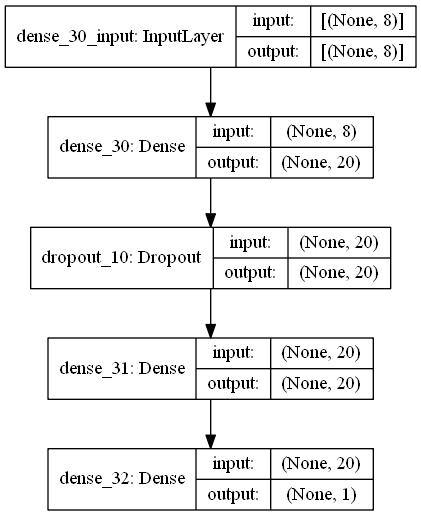

In [77]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Busca por hyperparâmetros

In [82]:
def cria_modelo(hp):
    model = tf.keras.models.Sequential()
    model.add(Dense(hp.Int('dense1', min_value=10, max_value=50, step=5, default=30), 
                    input_dim=X.shape[1], activation='relu'))  # valores entre 10 e 50
    model.add(Dropout(hp.Float('dropout1', 0, 0.2, step=0.1, default=0.0)))
    model.add(Dense(hp.Int('dense2', min_value=10, max_value=50, step=5, default=30), 
                    input_dim=X.shape[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
    return model

In [83]:
tuner = kt.RandomSearch(
    cria_modelo,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=3,
    directory='bug2'
)

In [85]:
es = tf.keras.callbacks.EarlyStopping(patience=15)

In [86]:
tuner.search(
    X_train, y_train,
    validation_data=(X_test, y_test), 
    epochs=50, shuffle=True,
    callbacks = [es]
)

Trial 20 Complete [00h 00m 10s]
val_accuracy: 0.7111111084620158

Best val_accuracy So Far: 0.7274853785832723
Total elapsed time: 00h 04m 03s
INFO:tensorflow:Oracle triggered exit


In [89]:
parametros = tuner.get_best_hyperparameters(1)[0]
print(parametros.values)

{'dense1': 35, 'dropout1': 0.0, 'dense2': 45}


In [90]:
best_models = tuner.get_best_models(num_models=3)
best_model = best_models[0]

In [91]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 35)                315       
_________________________________________________________________
dropout (Dropout)            (None, 35)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 45)                1620      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 46        
Total params: 1,981
Trainable params: 1,981
Non-trainable params: 0
_________________________________________________________________


In [93]:
best_model.save('best_model.h5')